# Burst and Non-Burst Analysis Pipeline

 This notebook performs an analysis of bursting behavior
 from multiple `.abf` recordings. 

 It includes:

 1. Loading and processing voltage traces.
 2. Detecting spikes and bursts.
 3. Segmenting bursts and interburst (non-burst) regions.
 4. Computing descriptive and derivative-based metrics for each segment.
 5. Classifying bursts into *Square Wave*, *Parabolic*, or *Other* types.
 6. Dimensionality reduction using UMAP for visualization.
 7. Data visualization (Seaborn + Plotly).

 The workflow is designed to be scalable across multiple cells/sweeps,
 and to extract features suitable for exploratory or machine-learning analyses.

- **Load Libraries**

These imports cover data processing, statistics, signal detection,
dimensionality reduction, and visualization.

In [53]:
import os                          # For handling directories and file paths
import pyabf                       # Library for reading Axon Binary Files (.abf)
import numpy as np                 # Numerical computations
import pandas as pd                # DataFrame manipulation
from scipy.stats import skew, kurtosis   # Statistical shape descriptors
from scipy.signal import find_peaks      # Spike (peak) detection
%matplotlib widget                 

# ### Dimensionality Reduction & Machine Learning Tools
import umap                        # Nonlinear dimensionality reduction algorithm
from sklearn.preprocessing import StandardScaler  # Standardizes features before UMAP

# ### Visualization
import matplotlib.pyplot as plt    # Static plotting
import seaborn as sns              # Statistical plotting with styling
import plotly.express as px        # Interactive visualizations
import plotly.io as pio

# Set Plotly to open figures in the default browser window
pio.renderers.default = "browser"

- **Define Parameters**

 These parameters control spike detection, burst definition,
 and data organization.

In [54]:
folder_path = "bursting"   # Folder containing .abf recordings
threshold = -35            # Spike detection threshold (mV)
burst_threshold = 0.3      # Interspike interval threshold for defining bursts (s)
fs = 10000                 # Sampling frequency (Hz)
dt = 1 / fs                # Sampling interval (s)

# This list will accumulate computed features for *all* segments (burst and non-burst)
all_segment_metrics = []

- **Process All ABF Files, Spike Detection, Burst Detection, Segment Classification, Burst Type Classification, Compute Metrics per Segment**

We list every `.abf` file in the directory and process them sequentially.
Each file may contain several sweeps, which are analyzed independently.

In [55]:
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    # Loop Through Sweeps
    # Each sweep corresponds to a separate recording trace.
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX          # Time vector for the sweep
        voltage = abf.sweepY       # Voltage trace (membrane potential)

        # Spike Detection
        # We identify action potentials (spikes) based on voltage thresholding.
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs   # Convert indices to seconds

        # Burst Detection
        # Bursts are defined as groups of spikes separated by ISIs < burst_threshold.
        bursts = []
        if len(spike_times) >= 4:  # Require at least 2 spikes to define a burst
            isi = np.diff(spike_times)
            current_burst = [spike_times[0]]

            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    # End of a burst if ISI exceeds threshold
                    if len(current_burst) > 1:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]

            # Include last burst if it qualifies
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))


        # Segment Classification
        # We define continuous regions of data as either "Burst" or "Non-burst".
        # This will allow us to extract metrics from both active and quiet periods.

        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        if bursts:
            # Add pre-burst non-burst region
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            # Add interburst non-burst regions
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            # Add post-burst non-burst region
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            # No bursts detected: entire sweep is non-burst
            segments.append((time[0], time[-1], "Non-burst"))

        # Burst Type Classification
        # Bursts are classified based on their minimum voltage
        # relative to the mean voltage of the adjacent interburst regions.
        # - Square Wave: relatively flat depolarized bursts.
        # - Parabolic: bursts with deeper hyperpolarizations.
        # - Other: ambiguous or intermediate shapes.

        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):

            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                burst_min = np.min(voltage[seg_mask])

                # Compute mean voltage before and after the burst
                prev_mean, next_mean = np.nan, np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])

                inter_mean = np.nanmean([prev_mean, next_mean])

                # Compare burst minima to interburst baseline
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)


        # Compute Metrics per Segment
        # For each burst and non-burst segment, we calculate:
        # - Temporal: duration, number of spikes, mean ISI.
        # - Voltage-based: mean, std, min, max, skewness, kurtosis, area.
        # - Derivative-based: mean, std, min, max, skewness, kurtosis of dV/dt.

        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            # Detect peaks (spikes) within the segment
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            # Voltage-based metrics
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)  # Numerical integral of voltage

            # Derivative-based metrics
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Append all computed metrics to the master list
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

C:\Users\manur\AppData\Local\Temp\ipykernel_15316\3018890462.py:89: RuntimeWarning:

Mean of empty slice



- **Create DataFrame and Save to CSV**

We consolidate all computed segment metrics into a single DataFrame.

In [56]:
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

- **UMAP Dimensionality Reduction**

 We project the high-dimensional segment metrics into 2D space using UMAP
 to visualize clusters and relationships between burst types.

In [57]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
df = pd.read_csv("segment_voltage_metrics_with_ISI_and_peaks.csv")

# Extract feature matrix (X) and labels (y)
header = list(df)[4:]    # Numerical features start at "Duration"
X = np.array(df[header])
y = np.array(df.Burst_Type)

# Standardize features (critical for UMAP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute 2D UMAP embedding
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Combine embedding with burst labels
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



- **Visualization**

The following plots provide complementary visualizations
of the feature space and segment properties.

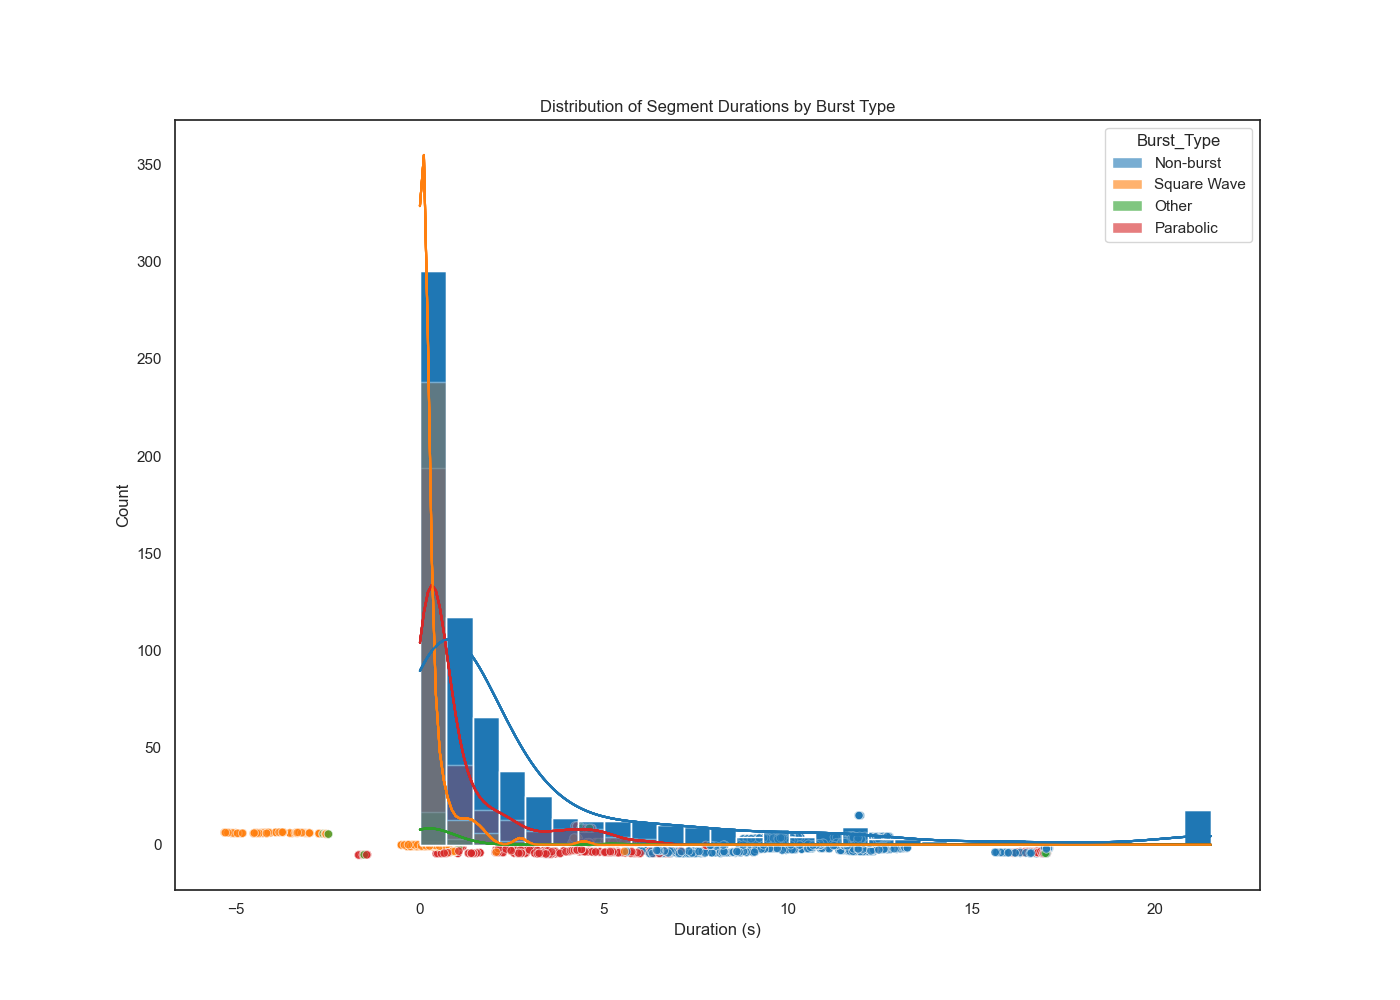

In [ ]:


# (a) Segment Duration Distribution
sns.set(style="whitegrid", context="notebook", rc={'figure.figsize':(10,6)})
sns.histplot(
    data=df_segments,
    x="Duration",
    hue="Burst_Type",
    bins=30,
    kde=True,
    palette="tab10",
    alpha=0.6
)
plt.title("Distribution of Segment Durations by Burst Type")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

# (b) Interactive Plotly UMAP Visualization
# Enables dynamic exploration of clusters by burst type.
fig = px.scatter(
    df_umap, x="UMAP1", y="UMAP2",
    color="Burst_Type",
    title="Interactive UMAP Visualization"
)
pio.renderers.default = "browser"
fig.show()